# Lecture Notes: ConvNets using Torch

We will be using Torch for this lab. We already know how to implement a linear layer and softmax layer. We will be re-using some code from the previous lab for Sections 1, and 2. In this lecture we will be exclusively using Torch, so the forward (prediction) and backward (gradient computation) functions are already implemented.

## 1. First let's load some training data. 
We will be using the CIFAR-10 dataset. CIFAR-10 is a dataset consisting of 50k training images belonging to 10 categories. A validation set is also provided which contains 10k images. We have a version of this dataset here that has all the images resized to 32x32. This is a relatively small dataset so it is very convenient to experiment with. You will probably read several papers reporting results on this dataset during this class but most state-of-the-art methods usually try experiments in much larger datasets with millions of images.

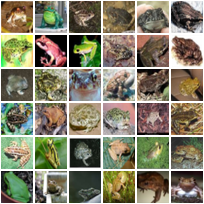

{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}
{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [1]:
require 'image'
-- The default tensor type in Torch is DoubleTensor, but we generally only need Float precision.
torch.setdefaulttensortype('torch.FloatTensor')

-- Load data.
trainset = torch.load('cifar10-train.t7') -- training images.
valset = torch.load('cifar10-val.t7')  -- validation set used to evaluate the model and tune parameters.
trainset.label = trainset.label + 1
valset.label = valset.label + 1
classes = {'airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck'}

-- Let's show all images of frogs.
class2ids = {}  -- Build a mapping between object names and class ids.
-- Remember that tables in lua are similar to (key,value) collections e.g. hashmaps.
for k,v in pairs(classes) do class2ids[v] = k end

-- Retrieve the frog class number.
object_class_id = class2ids['frog'] -- try changing this to visualize some images from other categories.
-- Put all images of frogs into a table.
objects = {}
local object_indices = trainset.label:eq(object_class_id):nonzero():squeeze()
for i = 1, 36 do  -- Let's show the first 36 frogs.
    table.insert(objects, trainset.data[object_indices[i]])
end

-- Plot the images of frogs using itorch.image
itorch.image(objects)
print(trainset) -- View what is inside the training set.
print(valset)  -- View what is inside the validation set.

## 2. Preprocessing and normalizing the data.
The images in this dataset are already pre-processed a bit, they are all 3x32x32, this means they have three channels (RGB), and they all have a width and height of 32 pixels. It is also generally a good idea in machine learning to center the inputs around zero. Each RGB value in our ByteTensor inputs goes from 0 to 255. We want the values to go from -1 to 1, if possible. This sometimes makes learning a function on these inputs easier. 

In [2]:
-- Make the data a FloatTensor.
trainset.normdata = trainset.data:clone():float()
valset.normdata = valset.data:clone():float()
cifarMean = {trainset.normdata[{{}, {1}, {}, {}}]:mean(),
             trainset.normdata[{{}, {2}, {}, {}}]:mean(),
             trainset.normdata[{{}, {3}, {}, {}}]:mean()}

cifarStd = {trainset.normdata[{{}, {1}, {}, {}}]:std(),
            trainset.normdata[{{}, {2}, {}, {}}]:std(),
            trainset.normdata[{{}, {3}, {}, {}}]:std()}

-- Print the mean and std value for each channel.
print(cifarMean)
print(cifarStd)

-- Now normalize the training and validation data.
for i  = 1, 3 do
    -- Subtracting the mean on each channel makes the values roughly between -128 and 128.
    trainset.normdata[{{}, {i}, {}, {}}]:add(-cifarMean[i])
    valset.normdata[{{}, {i}, {}, {}}]:add(-cifarMean[i])
    -- Dividing the std on each channel makes the values roughly between -1 and 1.
    trainset.normdata[{{}, {i}, {}, {}}]:div(cifarStd[i])
    valset.normdata[{{}, {i}, {}, {}}]:div(cifarStd[i])
end

{
  1 : 125.30691804687
  2 : 122.95039414062
  3 : 113.86538318359
}
{
  1 : 62.993219892912
  2 : 62.088708246722
  3 : 66.704900292063
}


## 3. Torch code for Linear Softmax + SGD from the last lecture

Here is the code that builds a linear model and runs mini-batch SGD to learn the parameters of the model. We will modify in this lab the model to 1) Use multiple two linear layers and a non-linear activation function. and 2) Use two convolutional layers and two linear layers. Additionally, I introduced some changes in the training loop to support a custom provided feature tensor, and a preprocessing function for later sections in this Lab.

In [3]:
require 'nn'  -- This library contains the classes we will need (Linear, LogSoftMax, ClassNLLCriterion)

local model = nn.Sequential()   -- Just a container of sequential operations.
model:add(nn.View(32 * 32 * 3))  -- This View layer vectorizes the images from a 3,32,32 tensor to a 3*32*32 vector.
model:add(nn.Linear(32 * 32 * 3, 10))  -- Linear transformation y = Wx + b
model:add(nn.LogSoftMax())  -- Log SoftMax function.

local criterion = nn.ClassNLLCriterion() -- Negative log-likelihood criterion.
-- params is a flat vector with the concatenation of all the parameters inside model.
-- gradParams is a flat vector with the concatenation of all the gradients of parameters inside the model.
-- These two variables also merely point to the internal individual parameters in each layer of the module.

function trainModel(model, opt, features, preprocessFn)
    -- Get all the parameters (and gradients) of the model in a single vector.
    local params, gradParams = model:getParameters()

    local opt = opt or {}
    local batchSize = opt.batchSize or 64  -- The bigger the batch size the most accurate the gradients.
    local learningRate = opt.learningRate or 0.001  -- This is the learning rate parameter often referred to as lambda.
    local momentumRate = opt.momentumRate or 0.9
    local numEpochs = opt.numEpochs or 3
    local velocityParams = torch.zeros(gradParams:size())
    local train_features, val_features
    if preprocessFn then
        train_features = trainset.data:float():div(255)
        val_features = valset.data:float():div(255)
    else
        train_features = (features and features.train_features) or trainset.normdata
        val_features = (features and features.val_features) or valset.normdata
    end
    -- Go over the training data this number of times.
    for epoch = 1, numEpochs do
        local sum_loss = 0
        local correct = 0
        --
        local validate_loss = 0
        
        -- Run over the training set samples.
        model:training()
        for i = 1, trainset.normdata:size(1) / batchSize do
            
            -- 1. Sample a batch.
            local inputs
            if preprocessFn then
                inputs = torch.Tensor(batchSize, 3, 224, 224)
            else
                inputs = (features and torch.Tensor(batchSize, 4096)) or torch.Tensor(batchSize, 3, 32, 32)
            end
            local labels = torch.Tensor(batchSize)
            for bi = 1, batchSize do
                local rand_id = torch.random(1, train_features:size(1))
                if preprocessFn then
                    inputs[bi] = preprocessFn(train_features[rand_id])
                else
                    inputs[bi] = train_features[rand_id]
                end
                labels[bi] = trainset.label[rand_id]
            end
            -- 2. Perform the forward pass (prediction mode).
            local predictions = model:forward(inputs)
            
            -- 3. Evaluate results.
            for i = 1, predictions:size(1) do
                local _, predicted_label = predictions[i]:max(1)
                if predicted_label[1] == labels[i] then correct = correct + 1 end
            end
            sum_loss = sum_loss + criterion:forward(predictions, labels)

            -- 4. Perform the backward pass (compute derivatives).
            -- This zeroes-out all the parameters inside the model pointed by variable params.
            model:zeroGradParameters()
            -- This internally computes the gradients with respect to the parameters pointed by gradParams.
            local gradPredictions = criterion:backward(predictions, labels)
            model:backward(inputs, gradPredictions)

            -- 5. Perform the SGD update.
            velocityParams:mul(momentumRate)
            velocityParams:add(learningRate, gradParams)
            params:add(-1, velocityParams)

            if i % 100 == 0 then  -- Print this every five thousand iterations.
                print(('train epoch=%d, iteration=%d, avg-loss=%.6f, avg-accuracy = %.2f')
                    :format(epoch, i, sum_loss / i, correct / (i * batchSize)))
            end
        end

        -- Run over the validation set for evaluation.
        local validation_accuracy = 0
        local nBatches = val_features:size(1) / batchSize
        model:evaluate()
        for i = 1, nBatches do
            
            -- 1. Sample a batch.
            if preprocessFn then
                inputs = torch.Tensor(batchSize, 3, 224, 224)
            else
                inputs = (features and torch.Tensor(batchSize, 4096)) or torch.Tensor(batchSize, 3, 32, 32)
            end
            local labels = torch.Tensor(batchSize)
            for bi = 1, batchSize do
                local rand_id = torch.random(1, val_features:size(1))
                if preprocessFn then
                    inputs[bi] = preprocessFn(val_features[rand_id])
                else
                    inputs[bi] = val_features[rand_id]
                end
                labels[bi] = valset.label[rand_id]
            end

            -- 2. Perform the forward pass (prediction mode).
            local predictions = model:forward(inputs)
            
            -- 3. evaluate results.
            for i = 1, predictions:size(1) do
                local _, predicted_label = predictions[i]:max(1)
                if predicted_label[1] == labels[i] then validation_accuracy = validation_accuracy + 1 end
            end
            validate_loss = validate_loss + criterion:forward(predictions, labels) --------
        end
        validation_accuracy = validation_accuracy / (nBatches * batchSize)
        validate_loss = validate_loss / (nBatches) ----------
        print(('\nvalidation accuracy at epoch = %d is %.4f, avg-loss=%.6f'):format(epoch, validation_accuracy, validate_loss))
    end
end

trainModel(model)

train epoch=1, iteration=100, avg-loss=1.994345, avg-accuracy = 0.30	


train epoch=1, iteration=200, avg-loss=1.947418, avg-accuracy = 0.32	


train epoch=1, iteration=300, avg-loss=1.916907, avg-accuracy = 0.34	


train epoch=1, iteration=400, avg-loss=1.889365, avg-accuracy = 0.35	


train epoch=1, iteration=500, avg-loss=1.877037, avg-accuracy = 0.35	


train epoch=1, iteration=600, avg-loss=1.868472, avg-accuracy = 0.36	


train epoch=1, iteration=700, avg-loss=1.856074, avg-accuracy = 0.36	



validation accuracy at epoch = 1 is 0.3800, avg-loss=1.819922	


train epoch=2, iteration=100, avg-loss=1.770794, avg-accuracy = 0.40	


train epoch=2, iteration=200, avg-loss=1.775577, avg-accuracy = 0.40	

train epoch=2, iteration=300, avg-loss=1.770499, avg-accuracy = 0.40	


train epoch=2, iteration=400, avg-loss=1.766531, avg-accuracy = 0.40	


train epoch=2, iteration=500, avg-loss=1.767240, avg-accuracy = 0.40	


train epoch=2, iteration=600, avg-loss=1.765737, avg-accuracy = 0.40	


train epoch=2, iteration=700, avg-loss=1.764718, avg-accuracy = 0.40	



validation accuracy at epoch = 2 is 0.3796, avg-loss=1.804994	


train epoch=3, iteration=100, avg-loss=1.742229, avg-accuracy = 0.42	


train epoch=3, iteration=200, avg-loss=1.749723, avg-accuracy = 0.41	


train epoch=3, iteration=300, avg-loss=1.746317, avg-accuracy = 0.41	


train epoch=3, iteration=400, avg-loss=1.744099, avg-accuracy = 0.41	


train epoch=3, iteration=500, avg-loss=1.743306, avg-accuracy = 0.41	


train epoch=3, iteration=600, avg-loss=1.737987, avg-accuracy = 0.41	


train epoch=3, iteration=700, avg-loss=1.737979, avg-accuracy = 0.41	



validation accuracy at epoch = 3 is 0.3871, avg-loss=1.802270	


## 4. Torch code for a 2-layer Neural Network.

We only need to modify the code for the model and add another linear layer and an activation function in-between.


In [4]:
local model = nn.Sequential()   -- Just a container of sequential operations.
model:add(nn.View(32 * 32 * 3))  -- This View layer vectorizes the images from a 3,32,32 tensor to a 3*32*32 vector.
model:add(nn.Linear(32 * 32 * 3, 500))  -- Linear transformation y = Wx + b
model:add(nn.ReLU())
model:add(nn.Linear(500, 10))  -- Linear transformation y = Wx + b
model:add(nn.LogSoftMax())  -- Log SoftMax function.

trainModel(model) -- Reuse our training code from earlier.

train epoch=1, iteration=100, avg-loss=2.035779, avg-accuracy = 0.28	


train epoch=1, iteration=200, avg-loss=1.932364, avg-accuracy = 0.32	


train epoch=1, iteration=300, avg-loss=1.877358, avg-accuracy = 0.34	


train epoch=1, iteration=400, avg-loss=1.833159, avg-accuracy = 0.36	


train epoch=1, iteration=500, avg-loss=1.799745, avg-accuracy = 0.37	


train epoch=1, iteration=600, avg-loss=1.767095, avg-accuracy = 0.38	


train epoch=1, iteration=700, avg-loss=1.743685, avg-accuracy = 0.39	



validation accuracy at epoch = 1 is 0.4366, avg-loss=1.614587	


train epoch=2, iteration=100, avg-loss=1.565190, avg-accuracy = 0.45	


train epoch=2, iteration=200, avg-loss=1.570884, avg-accuracy = 0.45	


train epoch=2, iteration=300, avg-loss=1.563464, avg-accuracy = 0.46	


train epoch=2, iteration=400, avg-loss=1.552145, avg-accuracy = 0.46	


train epoch=2, iteration=500, avg-loss=1.540793, avg-accuracy = 0.47	


train epoch=2, iteration=600, avg-loss=1.530988, avg-accuracy = 0.47	


train epoch=2, iteration=700, avg-loss=1.523303, avg-accuracy = 0.47	



validation accuracy at epoch = 2 is 0.4750, avg-loss=1.502819	


train epoch=3, iteration=100, avg-loss=1.464832, avg-accuracy = 0.50	


train epoch=3, iteration=200, avg-loss=1.455598, avg-accuracy = 0.50	


train epoch=3, iteration=300, avg-loss=1.453644, avg-accuracy = 0.50	


train epoch=3, iteration=400, avg-loss=1.443731, avg-accuracy = 0.50	


train epoch=3, iteration=500, avg-loss=1.437918, avg-accuracy = 0.50	


train epoch=3, iteration=600, avg-loss=1.434440, avg-accuracy = 0.51	


train epoch=3, iteration=700, avg-loss=1.431482, avg-accuracy = 0.51	



validation accuracy at epoch = 3 is 0.4870, avg-loss=1.453759	


Using the code above you probably experience a significant improvement in performance. Does adding more layers will keep improving perforamnce?

## 5. Torch code for a Convolutional Neural Network.

We pass the input image through two convolutional layers and then apply two linear layers. This model does not vectorize the input images right away. It first passes the images through two layers of convolutional filtering, then vectorizes this output and passes it to a neural network with two linear layers.

In [5]:
local model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 5, 5))  -- 3 input channels, 8 output channels (8 filters), 5x5 kernels.
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2)) -- Max pooling in 2 x 2 area.
model:add(nn.SpatialConvolution(8, 16, 5, 5))  -- 8 input channels, 16 output channels (16 filters), 5x5 kernels.
model:add(nn.ReLU())                      
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))  -- Max pooling in 2 x 2 area.
model:add(nn.View(16*5*5))   -- Vectorize the output of the convolutional layers.
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())  
model:add(nn.Linear(84, 10))
model:add(nn.LogSoftMax())

opt = {}
opt.learningRate = 0.01 -- bigger learning rate worked best for this network.
opt.batchSize = 32  -- smaller batch size, less accurate gradients, but more frequent updates.
opt.numEpochs = 5
trainModel(model, opt)

train epoch=1, iteration=100, avg-loss=2.209748, avg-accuracy = 0.18	


train epoch=1, iteration=200, avg-loss=2.120068, avg-accuracy = 0.22	


train epoch=1, iteration=300, avg-loss=2.038449, avg-accuracy = 0.25	


train epoch=1, iteration=400, avg-loss=1.965232, avg-accuracy = 0.27	


train epoch=1, iteration=500, avg-loss=1.908352, avg-accuracy = 0.29	


train epoch=1, iteration=600, avg-loss=1.859078, avg-accuracy = 0.31	


train epoch=1, iteration=700, avg-loss=1.821011, avg-accuracy = 0.33	


train epoch=1, iteration=800, avg-loss=1.787252, avg-accuracy = 0.34	


train epoch=1, iteration=900, avg-loss=1.757732, avg-accuracy = 0.35	


train epoch=1, iteration=1000, avg-loss=1.731232, avg-accuracy = 0.36	


train epoch=1, iteration=1100, avg-loss=1.710358, avg-accuracy = 0.37	


train epoch=1, iteration=1200, avg-loss=1.691706, avg-accuracy = 0.38	


train epoch=1, iteration=1300, avg-loss=1.673389, avg-accuracy = 0.39	


train epoch=1, iteration=1400, avg-loss=1.657320, avg-accuracy = 0.39	


train epoch=1, iteration=1500, avg-loss=1.643196, avg-accuracy = 0.40	



validation accuracy at epoch = 1 is 0.4988, avg-loss=1.415098	


train epoch=2, iteration=100, avg-loss=1.367954, avg-accuracy = 0.51	


train epoch=2, iteration=200, avg-loss=1.372279, avg-accuracy = 0.51	


train epoch=2, iteration=300, avg-loss=1.369349, avg-accuracy = 0.51	


train epoch=2, iteration=400, avg-loss=1.367578, avg-accuracy = 0.51	


train epoch=2, iteration=500, avg-loss=1.365237, avg-accuracy = 0.51	


train epoch=2, iteration=600, avg-loss=1.361994, avg-accuracy = 0.51	


train epoch=2, iteration=700, avg-loss=1.357245, avg-accuracy = 0.51	


train epoch=2, iteration=800, avg-loss=1.349050, avg-accuracy = 0.52	


train epoch=2, iteration=900, avg-loss=1.344369, avg-accuracy = 0.52	


train epoch=2, iteration=1000, avg-loss=1.335311, avg-accuracy = 0.52	


train epoch=2, iteration=1100, avg-loss=1.330531, avg-accuracy = 0.52	


train epoch=2, iteration=1200, avg-loss=1.327869, avg-accuracy = 0.53	


train epoch=2, iteration=1300, avg-loss=1.324028, avg-accuracy = 0.53	


train epoch=2, iteration=1400, avg-loss=1.320803, avg-accuracy = 0.53	


train epoch=2, iteration=1500, avg-loss=1.313425, avg-accuracy = 0.53	



validation accuracy at epoch = 2 is 0.5245, avg-loss=1.328819	


train epoch=3, iteration=100, avg-loss=1.265859, avg-accuracy = 0.55	


train epoch=3, iteration=200, avg-loss=1.249528, avg-accuracy = 0.56	


train epoch=3, iteration=300, avg-loss=1.245227, avg-accuracy = 0.56	


train epoch=3, iteration=400, avg-loss=1.246145, avg-accuracy = 0.56	


train epoch=3, iteration=500, avg-loss=1.233742, avg-accuracy = 0.56	


train epoch=3, iteration=600, avg-loss=1.222036, avg-accuracy = 0.57	


train epoch=3, iteration=700, avg-loss=1.213663, avg-accuracy = 0.57	


train epoch=3, iteration=800, avg-loss=1.205523, avg-accuracy = 0.58	


train epoch=3, iteration=900, avg-loss=1.197293, avg-accuracy = 0.58	


train epoch=3, iteration=1000, avg-loss=1.194188, avg-accuracy = 0.58	


train epoch=3, iteration=1100, avg-loss=1.191652, avg-accuracy = 0.58	


train epoch=3, iteration=1200, avg-loss=1.188528, avg-accuracy = 0.58	


train epoch=3, iteration=1300, avg-loss=1.183603, avg-accuracy = 0.58	


train epoch=3, iteration=1400, avg-loss=1.178325, avg-accuracy = 0.59	


train epoch=3, iteration=1500, avg-loss=1.178865, avg-accuracy = 0.59	



validation accuracy at epoch = 3 is 0.5865, avg-loss=1.191490	


train epoch=4, iteration=100, avg-loss=1.114032, avg-accuracy = 0.61	


train epoch=4, iteration=200, avg-loss=1.117478, avg-accuracy = 0.61	


train epoch=4, iteration=300, avg-loss=1.115975, avg-accuracy = 0.61	


train epoch=4, iteration=400, avg-loss=1.105395, avg-accuracy = 0.61	


train epoch=4, iteration=500, avg-loss=1.103655, avg-accuracy = 0.61	


train epoch=4, iteration=600, avg-loss=1.099953, avg-accuracy = 0.61	


train epoch=4, iteration=700, avg-loss=1.093527, avg-accuracy = 0.62	


train epoch=4, iteration=800, avg-loss=1.091220, avg-accuracy = 0.62	


train epoch=4, iteration=900, avg-loss=1.090664, avg-accuracy = 0.62	


train epoch=4, iteration=1000, avg-loss=1.086414, avg-accuracy = 0.62	


train epoch=4, iteration=1100, avg-loss=1.085772, avg-accuracy = 0.62	


train epoch=4, iteration=1200, avg-loss=1.083011, avg-accuracy = 0.62	


train epoch=4, iteration=1300, avg-loss=1.080072, avg-accuracy = 0.62	


train epoch=4, iteration=1400, avg-loss=1.077039, avg-accuracy = 0.62	


train epoch=4, iteration=1500, avg-loss=1.077566, avg-accuracy = 0.62	



validation accuracy at epoch = 4 is 0.5965, avg-loss=1.179878	


train epoch=5, iteration=100, avg-loss=1.022122, avg-accuracy = 0.64	

train epoch=5, iteration=200, avg-loss=1.052023, avg-accuracy = 0.64	


train epoch=5, iteration=300, avg-loss=1.038609, avg-accuracy = 0.64	


train epoch=5, iteration=400, avg-loss=1.033901, avg-accuracy = 0.64	


train epoch=5, iteration=500, avg-loss=1.038725, avg-accuracy = 0.64	


train epoch=5, iteration=600, avg-loss=1.030647, avg-accuracy = 0.64	


train epoch=5, iteration=700, avg-loss=1.039321, avg-accuracy = 0.64	


train epoch=5, iteration=800, avg-loss=1.031005, avg-accuracy = 0.64	


train epoch=5, iteration=900, avg-loss=1.030894, avg-accuracy = 0.64	


train epoch=5, iteration=1000, avg-loss=1.030607, avg-accuracy = 0.64	


train epoch=5, iteration=1100, avg-loss=1.028809, avg-accuracy = 0.64	


train epoch=5, iteration=1200, avg-loss=1.029571, avg-accuracy = 0.64	


train epoch=5, iteration=1300, avg-loss=1.030982, avg-accuracy = 0.64	


train epoch=5, iteration=1400, avg-loss=1.029924, avg-accuracy = 0.64	


train epoch=5, iteration=1500, avg-loss=1.028003, avg-accuracy = 0.64	



validation accuracy at epoch = 5 is 0.6053, avg-loss=1.186043	


## 6. Torch code for a Convolutional Neural Network with BatchNorm.

We pass the input image through two convolutional layers and then apply two linear layers. A good idea that has become recently popular is BatchNormalization which consists in a layer that normalizes the output of the previous layer in a similar way that we normalized the input in Section 2. Here is how to incorporate that. 

In [6]:
local model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 5, 5))  -- 3 input channels, 8 output channels (8 filters), 5x5 kernels.
model:add(nn.SpatialBatchNormalization(8, 1e-3))  -- BATCH NORMALIZATION LAYER.
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2)) -- Max pooling in 2 x 2 area.
model:add(nn.SpatialConvolution(8, 16, 5, 5))  -- 8 input channels, 16 output channels (16 filters), 5x5 kernels.
model:add(nn.SpatialBatchNormalization(16, 1e-3))  -- BATCH NORMALIZATION LAYER.
model:add(nn.ReLU())                      
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))  -- Max pooling in 2 x 2 area.
model:add(nn.View(16*5*5))    -- Vectorize the output of the convolutional layers.
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())  
model:add(nn.Linear(84, 10))
model:add(nn.LogSoftMax())

opt = {}
opt.learningRate = 0.02 -- bigger learning rate worked best for this network.
opt.batchSize = 32  -- smaller batch size, less accurate gradients, but more frequent updates.
opt.numEpochs = 5
trainModel(model, opt)  -- This will take a while!

train epoch=1, iteration=100, avg-loss=2.069967, avg-accuracy = 0.21	


train epoch=1, iteration=200, avg-loss=1.922900, avg-accuracy = 0.27	


train epoch=1, iteration=300, avg-loss=1.843852, avg-accuracy = 0.30	


train epoch=1, iteration=400, avg-loss=1.782154, avg-accuracy = 0.33	


train epoch=1, iteration=500, avg-loss=1.738306, avg-accuracy = 0.35	


train epoch=1, iteration=600, avg-loss=1.705821, avg-accuracy = 0.36	


train epoch=1, iteration=700, avg-loss=1.675042, avg-accuracy = 0.38	


train epoch=1, iteration=800, avg-loss=1.650378, avg-accuracy = 0.39	


train epoch=1, iteration=900, avg-loss=1.623889, avg-accuracy = 0.40	


train epoch=1, iteration=1000, avg-loss=1.605479, avg-accuracy = 0.41	


train epoch=1, iteration=1100, avg-loss=1.582210, avg-accuracy = 0.42	


train epoch=1, iteration=1200, avg-loss=1.566576, avg-accuracy = 0.42	


train epoch=1, iteration=1300, avg-loss=1.552133, avg-accuracy = 0.43	


train epoch=1, iteration=1400, avg-loss=1.537525, avg-accuracy = 0.44	


train epoch=1, iteration=1500, avg-loss=1.524209, avg-accuracy = 0.44	



validation accuracy at epoch = 1 is 0.5028, avg-loss=1.374461	


train epoch=2, iteration=100, avg-loss=1.278611, avg-accuracy = 0.54	


train epoch=2, iteration=200, avg-loss=1.275450, avg-accuracy = 0.54	


train epoch=2, iteration=300, avg-loss=1.271520, avg-accuracy = 0.55	


train epoch=2, iteration=400, avg-loss=1.267258, avg-accuracy = 0.55	


train epoch=2, iteration=500, avg-loss=1.254384, avg-accuracy = 0.55	


train epoch=2, iteration=600, avg-loss=1.253928, avg-accuracy = 0.55	


train epoch=2, iteration=700, avg-loss=1.249127, avg-accuracy = 0.55	


train epoch=2, iteration=800, avg-loss=1.246109, avg-accuracy = 0.56	


train epoch=2, iteration=900, avg-loss=1.238312, avg-accuracy = 0.56	


train epoch=2, iteration=1000, avg-loss=1.235657, avg-accuracy = 0.56	


train epoch=2, iteration=1100, avg-loss=1.234403, avg-accuracy = 0.56	


train epoch=2, iteration=1200, avg-loss=1.229673, avg-accuracy = 0.56	


train epoch=2, iteration=1300, avg-loss=1.225865, avg-accuracy = 0.56	


train epoch=2, iteration=1400, avg-loss=1.220428, avg-accuracy = 0.57	


train epoch=2, iteration=1500, avg-loss=1.216512, avg-accuracy = 0.57	



validation accuracy at epoch = 2 is 0.5742, avg-loss=1.203937	


train epoch=3, iteration=100, avg-loss=1.109746, avg-accuracy = 0.61	


train epoch=3, iteration=200, avg-loss=1.105617, avg-accuracy = 0.61	


train epoch=3, iteration=300, avg-loss=1.107688, avg-accuracy = 0.61	


train epoch=3, iteration=400, avg-loss=1.104371, avg-accuracy = 0.61	


train epoch=3, iteration=500, avg-loss=1.097785, avg-accuracy = 0.61	


train epoch=3, iteration=600, avg-loss=1.090666, avg-accuracy = 0.61	


train epoch=3, iteration=700, avg-loss=1.091219, avg-accuracy = 0.61	


train epoch=3, iteration=800, avg-loss=1.092379, avg-accuracy = 0.61	


train epoch=3, iteration=900, avg-loss=1.091996, avg-accuracy = 0.61	


train epoch=3, iteration=1000, avg-loss=1.091109, avg-accuracy = 0.61	


train epoch=3, iteration=1100, avg-loss=1.089690, avg-accuracy = 0.61	


train epoch=3, iteration=1200, avg-loss=1.087553, avg-accuracy = 0.62	


train epoch=3, iteration=1300, avg-loss=1.084434, avg-accuracy = 0.62	


train epoch=3, iteration=1400, avg-loss=1.083120, avg-accuracy = 0.62	


train epoch=3, iteration=1500, avg-loss=1.081451, avg-accuracy = 0.62	



validation accuracy at epoch = 3 is 0.5960, avg-loss=1.162395	


train epoch=4, iteration=100, avg-loss=1.039793, avg-accuracy = 0.63	


train epoch=4, iteration=200, avg-loss=1.032230, avg-accuracy = 0.64	


train epoch=4, iteration=300, avg-loss=1.039894, avg-accuracy = 0.63	


train epoch=4, iteration=400, avg-loss=1.025205, avg-accuracy = 0.64	


train epoch=4, iteration=500, avg-loss=1.024583, avg-accuracy = 0.64	


train epoch=4, iteration=600, avg-loss=1.024828, avg-accuracy = 0.64	


train epoch=4, iteration=700, avg-loss=1.029587, avg-accuracy = 0.64	


train epoch=4, iteration=800, avg-loss=1.031802, avg-accuracy = 0.64	


train epoch=4, iteration=900, avg-loss=1.029123, avg-accuracy = 0.64	


train epoch=4, iteration=1000, avg-loss=1.023513, avg-accuracy = 0.64	


train epoch=4, iteration=1100, avg-loss=1.020985, avg-accuracy = 0.64	


train epoch=4, iteration=1200, avg-loss=1.020400, avg-accuracy = 0.64	


train epoch=4, iteration=1300, avg-loss=1.016137, avg-accuracy = 0.64	


train epoch=4, iteration=1400, avg-loss=1.013578, avg-accuracy = 0.64	


train epoch=4, iteration=1500, avg-loss=1.011858, avg-accuracy = 0.64	



validation accuracy at epoch = 4 is 0.5968, avg-loss=1.140597	


train epoch=5, iteration=100, avg-loss=0.938976, avg-accuracy = 0.68	


train epoch=5, iteration=200, avg-loss=0.963312, avg-accuracy = 0.66	


train epoch=5, iteration=300, avg-loss=0.952208, avg-accuracy = 0.67	


train epoch=5, iteration=400, avg-loss=0.951623, avg-accuracy = 0.67	


train epoch=5, iteration=500, avg-loss=0.959334, avg-accuracy = 0.66	


train epoch=5, iteration=600, avg-loss=0.959337, avg-accuracy = 0.66	


train epoch=5, iteration=700, avg-loss=0.961243, avg-accuracy = 0.66	


train epoch=5, iteration=800, avg-loss=0.959155, avg-accuracy = 0.66	


train epoch=5, iteration=900, avg-loss=0.963246, avg-accuracy = 0.66	


train epoch=5, iteration=1000, avg-loss=0.958815, avg-accuracy = 0.66	


train epoch=5, iteration=1100, avg-loss=0.957740, avg-accuracy = 0.66	


train epoch=5, iteration=1200, avg-loss=0.957847, avg-accuracy = 0.66	


train epoch=5, iteration=1300, avg-loss=0.954436, avg-accuracy = 0.67	


train epoch=5, iteration=1400, avg-loss=0.950461, avg-accuracy = 0.67	


train epoch=5, iteration=1500, avg-loss=0.947686, avg-accuracy = 0.67	



validation accuracy at epoch = 5 is 0.6441, avg-loss=1.030923	


## 7. Running a pre-trained Imagenet Model on your Images

As you start realizing from the last experiment, it can take very long to train one of these models (and require much more memory), especially if you have many convolutional layers with hundreds of filters. The state-of-the-art models contain up to 150 layers (here we used 4) and are trained with at least 1 million images (here we used 50k) to predict 1000 categories (here we used 10). Training these models requires days or weeks of training using a GPU or an array of them. GPUs can accelerate the operations of these models up to 70x compared to using CPUs.

In our experiment below we will execute a variant of the AlexNet model, which was the architecture proposed in:<div style="padding:10px">
ImageNet Classification with Deep Convolutional Neural Networks, <b>NIPS 2012</b>. [<a href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">pdf</a>]<br/>
by <em>Alex Krizhevsky, Ilya Sutskever, and Geoff Hinton</em>.
</div>
This network has 5 convolutional layers and 2 linear layers. It was trained to classify 1000 image categories from the Imagenet Large Scale Visual Recognition Challenge <a href="http://www.image-net.org/challenges/LSVRC/">ILSVRC</a> (1 million training images, 50k validation images), and it originally took weeks to train on an array of 2 GPUs. This model right here I trained it myself and it took about a week using only one Titan X GPU, and I used the publicly available code from [<a href="https://github.com/soumith/imagenet-multiGPU.torch">here</a>].

In [2]:
require 'nn' -- just in case not loaded earlier.

-- Load the class list.
imagenetClasses = torch.load('alexnetowtbn_classes.t7')   -- This is the list of 1000 classes of Imagenet ILSVRC.
meanStd = torch.load('alexnetowtbn_meanStd.t7')  -- This is the mean and std used for normalizing images.

-- Load the model.
model = torch.load('alexnetowtbn_epoch55_cpu.t7')
model:evaluate()  -- Turn on evaluate mode. This is important for layers like BatchNorm or Dropout!
-- print(model)  -- This shows detailed information about every layer in the model.

Here I'm showing using an image the relevant parts of how this model is composed. The convolutional layers in charge of feature extraction are grouped under a Sequential container, and the classification layers are grouped in a second Sequential container:<img src="alexnetowtbn.png"/>

Now that we have our model loaded let's run an image through it and examine its predictions. Note that this model was trained using images resized to 256x256 and taking a center crop of size 224x224. We can up-size images from CIFAR-10 and run them through the network. Let's try that with an image of a frog or a bird.

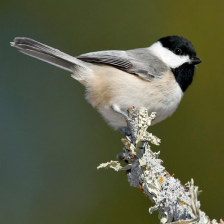

[n01592084 chickadee] = 0.99978	
[n01560419 bulbul] = 0.00010	


[n01580077 jay] = 0.00006	
[n01582220 magpie] = 0.00005	
[n01534433 junco, snowbird] = 0.00001	


In [3]:
local input_image = image.load('bird.jpg', 3, 'float') -- make it a float and between 0 and 1.
input_image = image.scale(input_image, 224, 224)  -- resize to the appropriate input for this network.
itorch.image(input_image)

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

input_image = preprocess(input_image):view(1, 3, 224, 224) -- put it in batch form by adding another dimension.

local predictions = model:forward(input_image)
-- Remember that the last layer is a LogSoftMax so we need to exp() that.
local scores, classIds = predictions[1]:exp():sort(true) 

for i = 1, 5 do
    print(('[%s] = %.5f'):format(imagenetClasses[classIds[i]], scores[i]))
end

## 8. Transfer learning I: Intermediate Network Outputs as Features

A powerful idea is using the pre-trained network on Imagenet and repurpose it for other tasks. A simple way to do this is using the activations of the network from the layer before the last linear layer as image features. Let's try to do this for the CIFAR task that we were training earlier. First, let's compute the activations for the last convolutional layer for all images to use these as features (just like we used the vectorized image representation, or color histograms). The following code will probably take a while (about 30 minutes). If you have a GPU this code will be blazing fast. There are a few modifications you will have to make to the code so it runs in the GPU (e.g. model:cuda(), batchTensor:cuda(), and maybe model = cudnn.convert(model, cudnn) to add cudnn support)

In [10]:

function compute_features(input_images)
    -- Create a tensor to hold the feature vectors.
    local features = torch.FloatTensor(input_images:size(1), 4096):zero()
    local batch_size = 250   -- Let's process images in groups of 128.
    for i = 1, input_images:size(1) / batch_size do
        local batchTensor = torch.FloatTensor(batch_size, 3, 224, 224)
        for j = 1, batch_size do
            local im = input_images[(i - 1) * batch_size + j]
            batchTensor[j] = preprocess(im)
        end
        -- Pass the pre-processed images through the network but discard the predictions.
        model:forward(batchTensor)
        -- Store the intermediate results from the layer before the prediction layer.
        for j = 1, batch_size do
            features[(i - 1) * batch_size + j] = model:get(2):get(9).output[j]
        end
        print(('%d. Features computed for %d out of %d images'):format(i, i * batch_size, input_images:size(1)))
    end
    return features
end

local train_images = trainset.data:float():div(255)
local val_images = valset.data:float():div(255)
features = {}
features.train_features = compute_features(train_images)
features.val_features = compute_features(val_images)
torch.save('alexnet_features.t7', features)  -- just in case this notebook gets closed.

1. Features computed for 250 out of 50000 images	


2. Features computed for 500 out of 50000 images	


3. Features computed for 750 out of 50000 images	


4. Features computed for 1000 out of 50000 images	


5. Features computed for 1250 out of 50000 images	


6. Features computed for 1500 out of 50000 images	


7. Features computed for 1750 out of 50000 images	


8. Features computed for 2000 out of 50000 images	


9. Features computed for 2250 out of 50000 images	


10. Features computed for 2500 out of 50000 images	


11. Features computed for 2750 out of 50000 images	


12. Features computed for 3000 out of 50000 images	


13. Features computed for 3250 out of 50000 images	


14. Features computed for 3500 out of 50000 images	


15. Features computed for 3750 out of 50000 images	


16. Features computed for 4000 out of 50000 images	


17. Features computed for 4250 out of 50000 images	


18. Features computed for 4500 out of 50000 images	


19. Features computed for 4750 out of 50000 images	


20. Features computed for 5000 out of 50000 images	


21. Features computed for 5250 out of 50000 images	


22. Features computed for 5500 out of 50000 images	


23. Features computed for 5750 out of 50000 images	


24. Features computed for 6000 out of 50000 images	


25. Features computed for 6250 out of 50000 images	


26. Features computed for 6500 out of 50000 images	


27. Features computed for 6750 out of 50000 images	


28. Features computed for 7000 out of 50000 images	


29. Features computed for 7250 out of 50000 images	


30. Features computed for 7500 out of 50000 images	


31. Features computed for 7750 out of 50000 images	


32. Features computed for 8000 out of 50000 images	


33. Features computed for 8250 out of 50000 images	


34. Features computed for 8500 out of 50000 images	


35. Features computed for 8750 out of 50000 images	


36. Features computed for 9000 out of 50000 images	


37. Features computed for 9250 out of 50000 images	


38. Features computed for 9500 out of 50000 images	


39. Features computed for 9750 out of 50000 images	


40. Features computed for 10000 out of 50000 images	


41. Features computed for 10250 out of 50000 images	


42. Features computed for 10500 out of 50000 images	


43. Features computed for 10750 out of 50000 images	


44. Features computed for 11000 out of 50000 images	


45. Features computed for 11250 out of 50000 images	


46. Features computed for 11500 out of 50000 images	


47. Features computed for 11750 out of 50000 images	


48. Features computed for 12000 out of 50000 images	


49. Features computed for 12250 out of 50000 images	


50. Features computed for 12500 out of 50000 images	


51. Features computed for 12750 out of 50000 images	


52. Features computed for 13000 out of 50000 images	


53. Features computed for 13250 out of 50000 images	


54. Features computed for 13500 out of 50000 images	


55. Features computed for 13750 out of 50000 images	


56. Features computed for 14000 out of 50000 images	


57. Features computed for 14250 out of 50000 images	


58. Features computed for 14500 out of 50000 images	


59. Features computed for 14750 out of 50000 images	


60. Features computed for 15000 out of 50000 images	


61. Features computed for 15250 out of 50000 images	


62. Features computed for 15500 out of 50000 images	


63. Features computed for 15750 out of 50000 images	


64. Features computed for 16000 out of 50000 images	


65. Features computed for 16250 out of 50000 images	


66. Features computed for 16500 out of 50000 images	


67. Features computed for 16750 out of 50000 images	


68. Features computed for 17000 out of 50000 images	


69. Features computed for 17250 out of 50000 images	


70. Features computed for 17500 out of 50000 images	


71. Features computed for 17750 out of 50000 images	


72. Features computed for 18000 out of 50000 images	


73. Features computed for 18250 out of 50000 images	


74. Features computed for 18500 out of 50000 images	


75. Features computed for 18750 out of 50000 images	


76. Features computed for 19000 out of 50000 images	


77. Features computed for 19250 out of 50000 images	


78. Features computed for 19500 out of 50000 images	


79. Features computed for 19750 out of 50000 images	


80. Features computed for 20000 out of 50000 images	


81. Features computed for 20250 out of 50000 images	


82. Features computed for 20500 out of 50000 images	


83. Features computed for 20750 out of 50000 images	


84. Features computed for 21000 out of 50000 images	


85. Features computed for 21250 out of 50000 images	


86. Features computed for 21500 out of 50000 images	


87. Features computed for 21750 out of 50000 images	


88. Features computed for 22000 out of 50000 images	


89. Features computed for 22250 out of 50000 images	


90. Features computed for 22500 out of 50000 images	


91. Features computed for 22750 out of 50000 images	


92. Features computed for 23000 out of 50000 images	


93. Features computed for 23250 out of 50000 images	


94. Features computed for 23500 out of 50000 images	


95. Features computed for 23750 out of 50000 images	


96. Features computed for 24000 out of 50000 images	


97. Features computed for 24250 out of 50000 images	


98. Features computed for 24500 out of 50000 images	


99. Features computed for 24750 out of 50000 images	


100. Features computed for 25000 out of 50000 images	


101. Features computed for 25250 out of 50000 images	


102. Features computed for 25500 out of 50000 images	


103. Features computed for 25750 out of 50000 images	


104. Features computed for 26000 out of 50000 images	


105. Features computed for 26250 out of 50000 images	


106. Features computed for 26500 out of 50000 images	


107. Features computed for 26750 out of 50000 images	


108. Features computed for 27000 out of 50000 images	


109. Features computed for 27250 out of 50000 images	


110. Features computed for 27500 out of 50000 images	


111. Features computed for 27750 out of 50000 images	


112. Features computed for 28000 out of 50000 images	


113. Features computed for 28250 out of 50000 images	


114. Features computed for 28500 out of 50000 images	


115. Features computed for 28750 out of 50000 images	


116. Features computed for 29000 out of 50000 images	


117. Features computed for 29250 out of 50000 images	


118. Features computed for 29500 out of 50000 images	


119. Features computed for 29750 out of 50000 images	


120. Features computed for 30000 out of 50000 images	


121. Features computed for 30250 out of 50000 images	


122. Features computed for 30500 out of 50000 images	


123. Features computed for 30750 out of 50000 images	


124. Features computed for 31000 out of 50000 images	


125. Features computed for 31250 out of 50000 images	


126. Features computed for 31500 out of 50000 images	


127. Features computed for 31750 out of 50000 images	


128. Features computed for 32000 out of 50000 images	


129. Features computed for 32250 out of 50000 images	


130. Features computed for 32500 out of 50000 images	


131. Features computed for 32750 out of 50000 images	


132. Features computed for 33000 out of 50000 images	


133. Features computed for 33250 out of 50000 images	


134. Features computed for 33500 out of 50000 images	


135. Features computed for 33750 out of 50000 images	


136. Features computed for 34000 out of 50000 images	


137. Features computed for 34250 out of 50000 images	


138. Features computed for 34500 out of 50000 images	


139. Features computed for 34750 out of 50000 images	


140. Features computed for 35000 out of 50000 images	


141. Features computed for 35250 out of 50000 images	


142. Features computed for 35500 out of 50000 images	


143. Features computed for 35750 out of 50000 images	


144. Features computed for 36000 out of 50000 images	


145. Features computed for 36250 out of 50000 images	


146. Features computed for 36500 out of 50000 images	


147. Features computed for 36750 out of 50000 images	


148. Features computed for 37000 out of 50000 images	


149. Features computed for 37250 out of 50000 images	


150. Features computed for 37500 out of 50000 images	


151. Features computed for 37750 out of 50000 images	


152. Features computed for 38000 out of 50000 images	


153. Features computed for 38250 out of 50000 images	


154. Features computed for 38500 out of 50000 images	


155. Features computed for 38750 out of 50000 images	


156. Features computed for 39000 out of 50000 images	


157. Features computed for 39250 out of 50000 images	


158. Features computed for 39500 out of 50000 images	


159. Features computed for 39750 out of 50000 images	


160. Features computed for 40000 out of 50000 images	


161. Features computed for 40250 out of 50000 images	


162. Features computed for 40500 out of 50000 images	


163. Features computed for 40750 out of 50000 images	


164. Features computed for 41000 out of 50000 images	


165. Features computed for 41250 out of 50000 images	


166. Features computed for 41500 out of 50000 images	


167. Features computed for 41750 out of 50000 images	


168. Features computed for 42000 out of 50000 images	


169. Features computed for 42250 out of 50000 images	


170. Features computed for 42500 out of 50000 images	


171. Features computed for 42750 out of 50000 images	


172. Features computed for 43000 out of 50000 images	


173. Features computed for 43250 out of 50000 images	


174. Features computed for 43500 out of 50000 images	


175. Features computed for 43750 out of 50000 images	


176. Features computed for 44000 out of 50000 images	


177. Features computed for 44250 out of 50000 images	


178. Features computed for 44500 out of 50000 images	


179. Features computed for 44750 out of 50000 images	


180. Features computed for 45000 out of 50000 images	


181. Features computed for 45250 out of 50000 images	


182. Features computed for 45500 out of 50000 images	


183. Features computed for 45750 out of 50000 images	


184. Features computed for 46000 out of 50000 images	


185. Features computed for 46250 out of 50000 images	


186. Features computed for 46500 out of 50000 images	


187. Features computed for 46750 out of 50000 images	


188. Features computed for 47000 out of 50000 images	


189. Features computed for 47250 out of 50000 images	


190. Features computed for 47500 out of 50000 images	


191. Features computed for 47750 out of 50000 images	


192. Features computed for 48000 out of 50000 images	


193. Features computed for 48250 out of 50000 images	


194. Features computed for 48500 out of 50000 images	


195. Features computed for 48750 out of 50000 images	


196. Features computed for 49000 out of 50000 images	


197. Features computed for 49250 out of 50000 images	


198. Features computed for 49500 out of 50000 images	


199. Features computed for 49750 out of 50000 images	


200. Features computed for 50000 out of 50000 images	


1. Features computed for 250 out of 10000 images	


2. Features computed for 500 out of 10000 images	


3. Features computed for 750 out of 10000 images	


4. Features computed for 1000 out of 10000 images	


5. Features computed for 1250 out of 10000 images	


6. Features computed for 1500 out of 10000 images	


7. Features computed for 1750 out of 10000 images	


8. Features computed for 2000 out of 10000 images	


9. Features computed for 2250 out of 10000 images	


10. Features computed for 2500 out of 10000 images	


11. Features computed for 2750 out of 10000 images	


12. Features computed for 3000 out of 10000 images	


13. Features computed for 3250 out of 10000 images	


14. Features computed for 3500 out of 10000 images	


15. Features computed for 3750 out of 10000 images	


16. Features computed for 4000 out of 10000 images	


17. Features computed for 4250 out of 10000 images	


18. Features computed for 4500 out of 10000 images	


19. Features computed for 4750 out of 10000 images	


20. Features computed for 5000 out of 10000 images	


21. Features computed for 5250 out of 10000 images	


22. Features computed for 5500 out of 10000 images	


23. Features computed for 5750 out of 10000 images	


24. Features computed for 6000 out of 10000 images	


25. Features computed for 6250 out of 10000 images	


26. Features computed for 6500 out of 10000 images	


27. Features computed for 6750 out of 10000 images	


28. Features computed for 7000 out of 10000 images	


29. Features computed for 7250 out of 10000 images	


30. Features computed for 7500 out of 10000 images	


31. Features computed for 7750 out of 10000 images	


32. Features computed for 8000 out of 10000 images	


33. Features computed for 8250 out of 10000 images	


34. Features computed for 8500 out of 10000 images	


35. Features computed for 8750 out of 10000 images	


36. Features computed for 9000 out of 10000 images	


37. Features computed for 9250 out of 10000 images	


38. Features computed for 9500 out of 10000 images	


39. Features computed for 9750 out of 10000 images	


40. Features computed for 10000 out of 10000 images	


Now let's just try a 2-layer neural network using the computed features.

In [11]:
-- features = torch.load('alexnet_features.t7') -- in case these are not already in memory.

local model = nn.Sequential()   -- Just a container of sequential operations.
model:add(nn.Linear(4096, 500))  -- Linear transformation y = Wx + b
model:add(nn.ReLU())
model:add(nn.Linear(500, 10))  -- Linear transformation y = Wx + b
model:add(nn.LogSoftMax())  -- Log SoftMax function.

opt = {}
opt.learningRate = 0.01
opt.numEpochs = 5
trainModel(model, opt, features) -- Reuse our training code from earlier.

train epoch=1, iteration=100, avg-loss=1.197714, avg-accuracy = 0.59	


train epoch=1, iteration=200, avg-loss=0.999181, avg-accuracy = 0.65	


train epoch=1, iteration=300, avg-loss=0.898632, avg-accuracy = 0.69	


train epoch=1, iteration=400, avg-loss=0.844467, avg-accuracy = 0.71	


train epoch=1, iteration=500, avg-loss=0.807610, avg-accuracy = 0.72	


train epoch=1, iteration=600, avg-loss=0.780872, avg-accuracy = 0.73	


train epoch=1, iteration=700, avg-loss=0.760022, avg-accuracy = 0.74	



validation accuracy at epoch = 1 is 0.7770, avg-loss=0.631496	


train epoch=2, iteration=100, avg-loss=0.626774, avg-accuracy = 0.78	


train epoch=2, iteration=200, avg-loss=0.615186, avg-accuracy = 0.78	


train epoch=2, iteration=300, avg-loss=0.606098, avg-accuracy = 0.78	


train epoch=2, iteration=400, avg-loss=0.602462, avg-accuracy = 0.79	


train epoch=2, iteration=500, avg-loss=0.603250, avg-accuracy = 0.79	


train epoch=2, iteration=600, avg-loss=0.600193, avg-accuracy = 0.79	


train epoch=2, iteration=700, avg-loss=0.598958, avg-accuracy = 0.79	



validation accuracy at epoch = 2 is 0.7803, avg-loss=0.651105	


train epoch=3, iteration=100, avg-loss=0.583639, avg-accuracy = 0.80	


train epoch=3, iteration=200, avg-loss=0.563436, avg-accuracy = 0.80	


train epoch=3, iteration=300, avg-loss=0.554068, avg-accuracy = 0.81	


train epoch=3, iteration=400, avg-loss=0.554071, avg-accuracy = 0.80	


train epoch=3, iteration=500, avg-loss=0.549585, avg-accuracy = 0.81	


train epoch=3, iteration=600, avg-loss=0.548447, avg-accuracy = 0.81	


train epoch=3, iteration=700, avg-loss=0.547817, avg-accuracy = 0.81	



validation accuracy at epoch = 3 is 0.7935, avg-loss=0.582518	


train epoch=4, iteration=100, avg-loss=0.536021, avg-accuracy = 0.82	


train epoch=4, iteration=200, avg-loss=0.530920, avg-accuracy = 0.82	


train epoch=4, iteration=300, avg-loss=0.527013, avg-accuracy = 0.82	


train epoch=4, iteration=400, avg-loss=0.532778, avg-accuracy = 0.81	


train epoch=4, iteration=500, avg-loss=0.526386, avg-accuracy = 0.81	


train epoch=4, iteration=600, avg-loss=0.521249, avg-accuracy = 0.82	


train epoch=4, iteration=700, avg-loss=0.519782, avg-accuracy = 0.82	



validation accuracy at epoch = 4 is 0.7955, avg-loss=0.581075	


train epoch=5, iteration=100, avg-loss=0.483128, avg-accuracy = 0.83	


train epoch=5, iteration=200, avg-loss=0.483457, avg-accuracy = 0.83	


train epoch=5, iteration=300, avg-loss=0.490310, avg-accuracy = 0.83	


train epoch=5, iteration=400, avg-loss=0.493021, avg-accuracy = 0.83	


train epoch=5, iteration=500, avg-loss=0.492633, avg-accuracy = 0.83	


train epoch=5, iteration=600, avg-loss=0.493199, avg-accuracy = 0.83	


train epoch=5, iteration=700, avg-loss=0.492020, avg-accuracy = 0.83	



validation accuracy at epoch = 5 is 0.8045, avg-loss=0.548066	


## 9. Transfer learning II: Fine-tuning the Network

An even stronger tool for transfer learning is modifying and adapting the AlexNet network parameters directly using SGD for a different task. This process is often referred to as fine-tuning the network. Here I show code to perform that for CIFAR, this requires forward and backward propagation on this pre-trained network and it will be a slow process (unless you use a GPU for this part). 


In [ ]:
-- Make sure the AlexNet model is loaded.
require 'nn' -- Make sure nn is loaded.
model = torch.load('alexnetowtbn_epoch55_cpu.t7')

-- Remove the last Linear layer of the model which is meant to predict 1000 classes.
model:get(2):remove(11) -- Remove the LogSoftMax layer.
model:get(2):remove(10) -- Remove the last Linear layer (4096 -> 1000)

-- Replace this last layer with a new Linear layer meant to predict 10 classes.
model:add(nn.Linear(4096, 10))  -- Add back a Linear layer (4096 -> 10)
model:add(nn.LogSoftMax())  -- Add back the LogSoftMax layer.

opt = {}
opt.learningRate = 0.001
opt.numEpochs = 5
opt.batchSize = 16
trainModel(model, opt, {}, preprocess) -- Reuse our training code from earlier.

## Lab Questions
1. Include a table here reporting the loss and final accuracy for each model in Sections 4, 5, 6, and 8 (no need to run section 9 unless you have a GPU where you can easily run it).
+ Visualize the convolutional filters for the first convolutional layer of the model in section 5 before and after training. Do so by rescaling the values appropriately to show them as RGB images. (Check the Torch documentation to find how to retrieve them from the model variable) 
+ Similarly visualize the convolutional filters corresponding to the first convolutional layer of the pre-trained AlexNet model of section 7.
+ The AlexNet model that was used in this lab occupies 466MB. Include a table here detailing how much of this space is occupied layer by layer.
+ Why does the AlexNet model presented in this lab must have a nn.View layer with an input dimension of 9216? 
+ More powerful models were proposed after AlexNet, one of them is known as the VGG model (see code here https://github.com/soumith/imagenet-multiGPU.torch/blob/master/models/vggbn.lua), another one is the GoogLenet model (see code here https://github.com/soumith/imagenet-multiGPU.torch/blob/master/models/googlenet.lua). Describe here in one paragraph each, what are the architectural differences and innovations that you notice with respect to the AlexNet model (e.g. more layers? how many more? more filters? bigger convolutional filters? smaller convolutional filters? Just by looking at the code can you estimate which model occupies more memory VGG or GoogLenet?).

# Question 1


|                   |section 4|section 5|section 6|section 8|
|:------------------|--------:|--------:|--------:|--------:|
|train loss         |1.431482 |1.028003 |0.947686 |0.492020 |
|Validation Loss    |1.453759 |1.186043 |1.030923 |0.548066 |
|Train Accuracy     |0.51     |0.64     |0.67     |0.83     |
|Validation Accuracy|0.4870   |0.6053   |0.6441   |0.8045   |
|epoch number       |3        |5        |5        |5        |


# Question 2

nn.SpatialConvolution(3 -> 8, 5x5)
{
  dH : 1
  dW : 1
  nInputPlane : 3
  output : FloatTensor - empty
  kH : 5
  gradBias : FloatTensor - size: 8
  padH : 0
  bias : FloatTensor - size: 8
  weight : FloatTensor - size: 8x3x5x5
  _type : torch.FloatTensor
  gradWeight : FloatTensor - size: 8x3x5x5
  padW : 0
  nOutputPlane : 8
  kW : 5
  gradInput : FloatTensor - empty
}


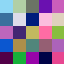

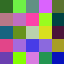

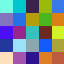

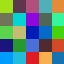

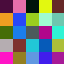

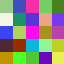

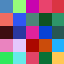

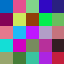

train epoch=1, iteration=100, avg-loss=2.274483, avg-accuracy = 0.13	


train epoch=1, iteration=200, avg-loss=2.140383, avg-accuracy = 0.20	


train epoch=1, iteration=300, avg-loss=2.042180, avg-accuracy = 0.24	


train epoch=1, iteration=400, avg-loss=1.966626, avg-accuracy = 0.27	


train epoch=1, iteration=500, avg-loss=1.903935, avg-accuracy = 0.30	


train epoch=1, iteration=600, avg-loss=1.860957, avg-accuracy = 0.32	


train epoch=1, iteration=700, avg-loss=1.815834, avg-accuracy = 0.33	


train epoch=1, iteration=800, avg-loss=1.779676, avg-accuracy = 0.35	


train epoch=1, iteration=900, avg-loss=1.754231, avg-accuracy = 0.36	


train epoch=1, iteration=1000, avg-loss=1.729569, avg-accuracy = 0.37	


train epoch=1, iteration=1100, avg-loss=1.706102, avg-accuracy = 0.38	


train epoch=1, iteration=1200, avg-loss=1.686632, avg-accuracy = 0.38	


train epoch=1, iteration=1300, avg-loss=1.668886, avg-accuracy = 0.39	


train epoch=1, iteration=1400, avg-loss=1.649922, avg-accuracy = 0.40	


train epoch=1, iteration=1500, avg-loss=1.634049, avg-accuracy = 0.40	



validation accuracy at epoch = 1 is 0.4819, avg-loss=1.454825	


train epoch=2, iteration=100, avg-loss=1.398222, avg-accuracy = 0.49	


train epoch=2, iteration=200, avg-loss=1.378489, avg-accuracy = 0.51	


train epoch=2, iteration=300, avg-loss=1.365839, avg-accuracy = 0.51	


train epoch=2, iteration=400, avg-loss=1.363271, avg-accuracy = 0.51	


train epoch=2, iteration=500, avg-loss=1.366437, avg-accuracy = 0.51	


train epoch=2, iteration=600, avg-loss=1.360821, avg-accuracy = 0.51	


train epoch=2, iteration=700, avg-loss=1.357456, avg-accuracy = 0.51	


train epoch=2, iteration=800, avg-loss=1.347955, avg-accuracy = 0.52	


train epoch=2, iteration=900, avg-loss=1.343826, avg-accuracy = 0.52	


train epoch=2, iteration=1000, avg-loss=1.340123, avg-accuracy = 0.52	


train epoch=2, iteration=1100, avg-loss=1.332336, avg-accuracy = 0.52	


train epoch=2, iteration=1200, avg-loss=1.329410, avg-accuracy = 0.52	


train epoch=2, iteration=1300, avg-loss=1.324638, avg-accuracy = 0.53	


train epoch=2, iteration=1400, avg-loss=1.318566, avg-accuracy = 0.53	


train epoch=2, iteration=1500, avg-loss=1.310346, avg-accuracy = 0.53	



validation accuracy at epoch = 2 is 0.5538, avg-loss=1.269368	


train epoch=3, iteration=100, avg-loss=1.214947, avg-accuracy = 0.57	


train epoch=3, iteration=200, avg-loss=1.211477, avg-accuracy = 0.57	


train epoch=3, iteration=300, avg-loss=1.193889, avg-accuracy = 0.58	


train epoch=3, iteration=400, avg-loss=1.196217, avg-accuracy = 0.58	


train epoch=3, iteration=500, avg-loss=1.196861, avg-accuracy = 0.58	


train epoch=3, iteration=600, avg-loss=1.194774, avg-accuracy = 0.58	


train epoch=3, iteration=700, avg-loss=1.195577, avg-accuracy = 0.58	


train epoch=3, iteration=800, avg-loss=1.194283, avg-accuracy = 0.58	


train epoch=3, iteration=900, avg-loss=1.190891, avg-accuracy = 0.58	


train epoch=3, iteration=1000, avg-loss=1.189308, avg-accuracy = 0.58	


train epoch=3, iteration=1100, avg-loss=1.182820, avg-accuracy = 0.58	


train epoch=3, iteration=1200, avg-loss=1.180797, avg-accuracy = 0.58	


train epoch=3, iteration=1300, avg-loss=1.176602, avg-accuracy = 0.59	


train epoch=3, iteration=1400, avg-loss=1.173446, avg-accuracy = 0.59	


train epoch=3, iteration=1500, avg-loss=1.169028, avg-accuracy = 0.59	



validation accuracy at epoch = 3 is 0.5634, avg-loss=1.248417	


train epoch=4, iteration=100, avg-loss=1.077063, avg-accuracy = 0.63	


train epoch=4, iteration=200, avg-loss=1.097903, avg-accuracy = 0.62	


train epoch=4, iteration=300, avg-loss=1.105175, avg-accuracy = 0.62	


train epoch=4, iteration=400, avg-loss=1.106323, avg-accuracy = 0.62	


train epoch=4, iteration=500, avg-loss=1.098641, avg-accuracy = 0.62	


train epoch=4, iteration=600, avg-loss=1.102169, avg-accuracy = 0.62	


train epoch=4, iteration=700, avg-loss=1.097471, avg-accuracy = 0.62	


train epoch=4, iteration=800, avg-loss=1.095713, avg-accuracy = 0.62	


train epoch=4, iteration=900, avg-loss=1.090948, avg-accuracy = 0.62	


train epoch=4, iteration=1000, avg-loss=1.087754, avg-accuracy = 0.62	


train epoch=4, iteration=1100, avg-loss=1.085536, avg-accuracy = 0.62	


train epoch=4, iteration=1200, avg-loss=1.084180, avg-accuracy = 0.62	


train epoch=4, iteration=1300, avg-loss=1.084056, avg-accuracy = 0.62	


train epoch=4, iteration=1400, avg-loss=1.081729, avg-accuracy = 0.62	


train epoch=4, iteration=1500, avg-loss=1.078177, avg-accuracy = 0.62	



validation accuracy at epoch = 4 is 0.6055, avg-loss=1.172294	


train epoch=5, iteration=100, avg-loss=1.073781, avg-accuracy = 0.62	


train epoch=5, iteration=200, avg-loss=1.057451, avg-accuracy = 0.63	


train epoch=5, iteration=300, avg-loss=1.065855, avg-accuracy = 0.63	


train epoch=5, iteration=400, avg-loss=1.060681, avg-accuracy = 0.63	


train epoch=5, iteration=500, avg-loss=1.049398, avg-accuracy = 0.64	


train epoch=5, iteration=600, avg-loss=1.042531, avg-accuracy = 0.64	


train epoch=5, iteration=700, avg-loss=1.036389, avg-accuracy = 0.64	


train epoch=5, iteration=800, avg-loss=1.036749, avg-accuracy = 0.64	


train epoch=5, iteration=900, avg-loss=1.036144, avg-accuracy = 0.64	


train epoch=5, iteration=1000, avg-loss=1.038679, avg-accuracy = 0.64	


train epoch=5, iteration=1100, avg-loss=1.035562, avg-accuracy = 0.64	


train epoch=5, iteration=1200, avg-loss=1.035672, avg-accuracy = 0.64	


train epoch=5, iteration=1300, avg-loss=1.035144, avg-accuracy = 0.64	


train epoch=5, iteration=1400, avg-loss=1.033924, avg-accuracy = 0.64	


train epoch=5, iteration=1500, avg-loss=1.034579, avg-accuracy = 0.64	



validation accuracy at epoch = 5 is 0.5790, avg-loss=1.234302	


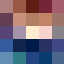

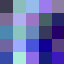

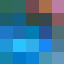

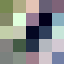

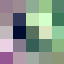

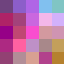

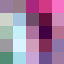

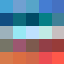

In [43]:
local model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 5, 5))  -- 3 input channels, 8 output channels (8 filters), 5x5 kernels.
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2)) -- Max pooling in 2 x 2 area.
model:add(nn.SpatialConvolution(8, 16, 5, 5))  -- 8 input channels, 16 output channels (16 filters), 5x5 kernels.
model:add(nn.ReLU())                      
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))  -- Max pooling in 2 x 2 area.
model:add(nn.View(16*5*5))   -- Vectorize the output of the convolutional layers.
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())  
model:add(nn.Linear(84, 10))
model:add(nn.LogSoftMax())

opt = {}
opt.learningRate = 0.01 -- bigger learning rate worked best for this network.
opt.batchSize = 32  -- smaller batch size, less accurate gradients, but more frequent updates.
opt.numEpochs = 5

print(model:get(1))

local image_1 = model:get(1).weight
for i =1,8 do
    local temp = image.scale(image_1[i], 64, 64, 'simple')
    itorch.image(temp)
end

trainModel(model, opt)


local image_1 = model:get(1).weight
for i =1,8 do
    local temp = image.scale(image_1[i], 64, 64, 'simple')
    itorch.image(temp)
end

# Question 3

nn.SpatialConvolution(3 -> 64, 11x11, 4,4, 2,2)
{
  padW : 2
  nInputPlane : 3
  output : FloatTensor - empty
  gradInput : FloatTensor - empty
  iSize : LongStorage - size: 4
  _type : torch.FloatTensor
  groups : 1
  dH : 4
  dW : 4
  output_offset : 200704
  padH : 2
  kH : 11
  weight_offset : 23232
  input_offset : 154587
  weight : FloatTensor - size: 64x3x11x11
  train : false
  gradWeight : FloatTensor - size: 64x3x11x11
  bias : FloatTensor - size: 64
  gradBias : FloatTensor - size: 64
  kW : 11
  nOutputPlane : 64
}


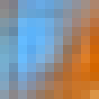

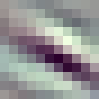

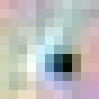

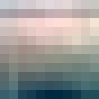

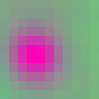

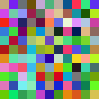

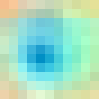

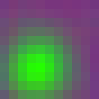

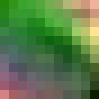

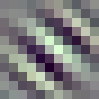

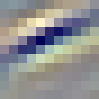

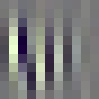

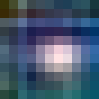

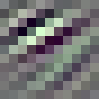

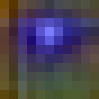

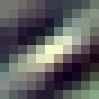

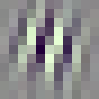

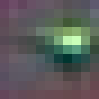

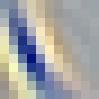

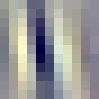

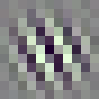

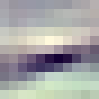

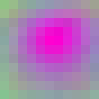

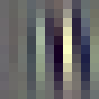

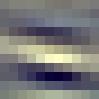

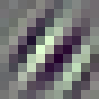

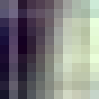

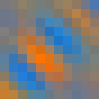

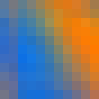

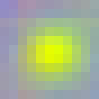

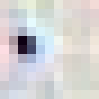

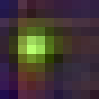

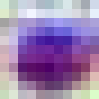

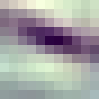

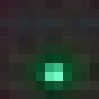

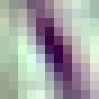

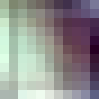

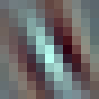

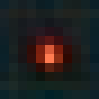

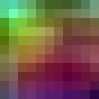

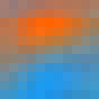

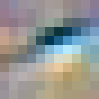

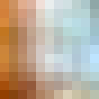

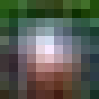

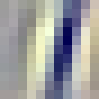

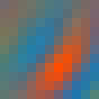

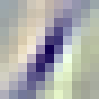

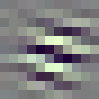

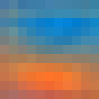

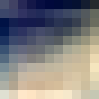

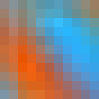

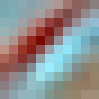

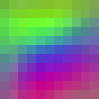

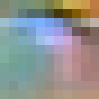

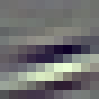

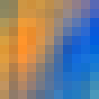

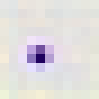

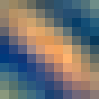

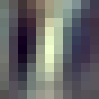

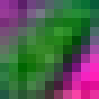

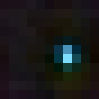

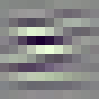

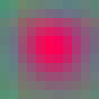

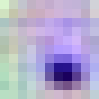

In [6]:
require 'nn' -- just in case not loaded earlier.

-- Load the class list.
imagenetClasses = torch.load('alexnetowtbn_classes.t7')   -- This is the list of 1000 classes of Imagenet ILSVRC.
meanStd = torch.load('alexnetowtbn_meanStd.t7')  -- This is the mean and std used for normalizing images.

-- Load the model.
model = torch.load('alexnetowtbn_epoch55_cpu.t7')
model:evaluate()  -- Turn on evaluate mode. This is important for layers like BatchNorm or Dropout!
-- print(model)  -- This shows detailed information about every layer in the model.

print(model:get(1):get(1))

local image_2 = model:get(1):get(1).weight
for i =1,64 do
    local temp = image.scale(image_2[i], 99, 99, 'simple')
    itorch.image(temp)
end

# Question 4
The AlexNet model that was used in this lab occupies 466MB. Include a table here detailing how much of this space is occupied layer by layer.

In [27]:
--print(model:get(1))

print(model:get(1))
print(model:get(2))


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> output]
  (1): nn.SpatialConvolution(3 -> 64, 11x11, 4,4, 2,2)
  (2): nn.SpatialBatchNormalization
  (3): nn.ReLU
  (4): nn.SpatialMaxPooling(3x3, 2,2)
  (5): nn.SpatialConvolution(64 -> 192, 5x5, 1,1, 2,2)
  (6): nn.SpatialBatchNormalization
  (7): nn.ReLU
  (8): nn.SpatialMaxPooling(3x3, 2,2)
  (9): nn.SpatialConvolution(192 -> 384, 3x3, 1,1, 1,1)
  (10): nn.SpatialBatchNormalization
  (11): nn.ReLU
  (12): nn.SpatialConvolution(384 -> 256, 3x3, 1,1, 1,1)
  (13): nn.SpatialBatchNormalization
  (14): nn.ReLU
  (15): nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
  (16): nn.SpatialBatchNormalization
  (17): nn.ReLU
  (18): nn.SpatialMaxPooling(3x3, 2,2)
}
{
  train : false
  output : FloatTensor - size: 1x256x6x6
  gradInput : FloatTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolution(3 -> 64, 11x11, 4,

          iwidth : 55
          output : FloatTensor - size: 1x64x27x27
          gradInput : FloatTensor - empty
          kH : 3
          iSize : LongStorage - size: 4
          _type : torch.FloatTensor
          indices : FloatTensor - size: 1x64x27x27
          mode : CUDNN_POOLING_MAX
          train : false
          padH : 0
          ceil_mode : false
          iheight : 55
          padW : 0
          kW : 3
        }
      5 : 
        nn.SpatialConvolution(64 -> 192, 5x5, 1,1, 2,2)
        {
          padW : 2
          nInputPlane : 64
          output : FloatTensor - size: 1x192x27x27
          gradInput : FloatTensor - empty
          iSize : LongStorage - size: 4
          _type : torch.FloatTensor
          groups : 1
          dH : 1
          dW : 1
          output_offset : 139968
          padH : 2
          kH : 5
          weight_offset : 307200
          finput : FloatTensor - size: 1x1600x729
          fgradInput : FloatTensor - empty
          input_offset : 

  {
          padW : 1
          nInputPlane : 192
          output : FloatTensor - size: 1x384x13x13
          gradInput : FloatTensor - empty
          iSize : LongStorage - size: 4
          _type : torch.FloatTensor
          groups : 1
          dH : 1
          dW : 1
          output_offset : 64896
          padH : 1
          kH : 3
          weight_offset : 663552
          finput : FloatTensor - size: 1x1728x169
          fgradInput : FloatTensor - empty
          input_offset : 32448
          weight : FloatTensor - size: 384x192x3x3
          train : false
          gradWeight : FloatTensor - size: 384x192x3x3
          bias : FloatTensor - size: 384
          gradBias : FloatTensor - size: 384
          kW : 3
          nOutputPlane : 384
        }
      10 : 
        nn.SpatialBatchNormalization
        {
          gradBias : FloatTensor - size: 384
          _type : torch.FloatTensor
          output : FloatTensor - size: 1x384x13x13
          gradInput : FloatTensor - e

          running_mean : FloatTensor - size: 256
          affine : true
          save_std : FloatTensor - size: 256
          bias : FloatTensor - size: 256
        }
      14 : 
        nn.ReLU
        {
          threshold : 0
          output : FloatTensor - size: 1x256x13x13
          gradInput : FloatTensor - empty
          inplace : true
          mode : CUDNN_ACTIVATION_RELU
          _type : torch.FloatTensor
          nElem : 5537792
          train : false
          val : 0
        }
      15 : 
        nn.SpatialConvolution(256 -> 256, 3x3, 1,1, 1,1)
        {
          padW : 1
          nInputPlane : 256
          output : FloatTensor - size: 1x256x13x13
          gradInput : FloatTensor - empty
          iSize : LongStorage - size: 4
          _type : torch.FloatTensor
          groups : 1
          dH : 1
          dW : 1
          output_offset : 43264
          padH : 1
          kH : 3
          weight_offset : 589824
          finput : FloatTensor - size: 1x2304x1

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> output]
  (1): nn.View(9216)
  (2): nn.Dropout(0.500000)
  (3): nn.Linear(9216 -> 4096)
  (4): nn.BatchNormalization
  (5): nn.ReLU
  (6): nn.Dropout(0.500000)
  (7): nn.Linear(4096 -> 4096)
  (8): nn.BatchNormalization
  (9): nn.ReLU
  (10): nn.Linear(4096 -> 1000)
  (11): nn.LogSoftMax
}
{
  train : false
  output : FloatTensor - size: 1x1000
  gradInput : FloatTensor - empty
  modules : 
    {
      1 : 
        nn.View(9216)
        {
          _type : torch.FloatTensor
          train : false
          output : FloatTensor - size: 1x9216
          gradInput : FloatTensor - empty
          numElements : 9216
          size : LongStorage - size: 1
          numInputDims : 3
        }
      2 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          noise : FloatTensor - empty
          train : false
          p : 0.5
          gradInput : FloatTensor - empty
     

      centered : FloatTensor - empty
          eps : 0.001
          train : false
          gradWeight : FloatTensor - size: 4096
          running_mean : FloatTensor - size: 4096
          buffer2 : FloatTensor - empty
          std : FloatTensor - empty
          weight : FloatTensor - size: 4096
        }
      9 : 
        nn.ReLU
        {
          threshold : 0
          output : FloatTensor - size: 1x4096
          gradInput : FloatTensor - empty
          inplace : false
          mode : CUDNN_ACTIVATION_RELU
          _type : torch.FloatTensor
          nElem : 524288
          train : false
          val : 0
        }
      10 : 
        nn.Linear(4096 -> 1000)
        {
          gradBias : FloatTensor - size: 1000
          output : FloatTensor - size: 1x1000
          gradInput : FloatTensor - empty
          weight : FloatTensor - size: 1000x4096
          train : false
          gradWeight : FloatTensor - size: 1000x4096
          addBuffer : FloatTensor - size: 1
    

In [16]:
local output = torch.Tensor(29)
output[1] = 64 * 3 * 11 * 11 + 64 * 3 * 11 * 11 + 64 + 64
output[2] = 64 * 6
output[3] = 0
output[4] = 0
output[5] = 192*64*5*5*2 + 192*2
output[6] = 192 * 6
output[7] = 0
output[8] = 0
output[9] = 384*192*3*3 * 2 + 384 * 2
output[10] = 384 * 6
output[11] = 0
output[12] = 256*384*3*3 *2 + 256 *2
output[13] = 256*6
output[14] = 0
output[15] = 256*256*3*3 *2 +256*2
output[16] = 256 * 6
output[17] = 0
output[18] = 0

output[19] = 0
output[20] = 0
output[21] = 4096*9216 *2 + 4096 *2
output[22] = 4096 *4
output[23] = 0
output[24] = 0
output[25] = 4096*4096 *2 + 4096 *2
output[26] = 4096*6
output[27] = 0
output[28] = 1000*4096 *2 + 1000*2
output[29] = 0
local a = 0;
for i =1,29 do
    a = a+output[i]
end
print(a*4/1000000)




488.998208	


# Question 5
Why does the AlexNet model presented in this lab must have a nn.View layer with an input dimension of 9216?

Because the imput of the image is 3x224x224, so the output size of first sequential layer 
is 1x256x6x6 = 9216. The output of first sequential layer is fed into the view layer, so its
input dimension has to be 9216.

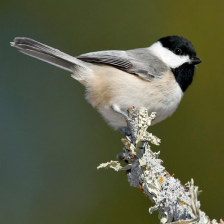

[n01592084 chickadee] = 0.99978	
[n01560419 bulbul] = 0.00010	
[n01580077 jay] = 0.00006	
[n01582220 magpie] = 0.00005	
[n01534433 junco, snowbird] = 0.00001	


   1
 256
   6
   6
[torch.LongStorage of size 4]



In [4]:
local input_image = image.load('bird.jpg', 3, 'float') -- make it a float and between 0 and 1.
input_image = image.scale(input_image, 224, 224)  -- resize to the appropriate input for this network.
itorch.image(input_image)

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

input_image = preprocess(input_image):view(1, 3, 224, 224) -- put it in batch form by adding another dimension.

local predictions = model:forward(input_image)
-- Remember that the last layer is a LogSoftMax so we need to exp() that.
local scores, classIds = predictions[1]:exp():sort(true) 

for i = 1, 5 do
    print(('[%s] = %.5f'):format(imagenetClasses[classIds[i]], scores[i]))
end

print(model:get(1).output:size())

# Question 6
More powerful models were proposed after AlexNet, one of them is known as the VGG model (see code here https://github.com/soumith/imagenet-multiGPU.torch/blob/master/models/vggbn.lua), another one is the GoogLenet model (see code here https://github.com/soumith/imagenet-multiGPU.torch/blob/master/models/googlenet.lua). Describe here in one paragraph each, what are the architectural differences and innovations that you notice with respect to the AlexNet model (e.g. more layers? how many more? more filters? bigger convolutional filters? smaller convolutional filters? Just by looking at the code can you estimate which model occupies more memory VGG or GoogLenet?).

Alexnet:
Conv: 3, 64, 11, 11
Conv: 64, 192, 5, 5
Conv: 192, 384, 3, 3
Conv: 384, 256, 3, 3
Conv: 256, 256, 3, 3

Linear: 9216 -> 4096
Linear: 4096 -> 4096
Linear: 4096 -> 1000


1: 
VGG: I am looking at modelType = 'A'. 
In this model, it has 8 convolution layers and 3 Linear layers.
AlexNet only has 5 convolution layers and 3 Linear layers.
VGG model has 64+128+256+256+512+512+512+512 = 2752 filters.
AlexNet has 64+192+384+256+256 = 1152 filters.
In VGG model, all filters has a size of 3x3. 
AlexNet has some bigger filters sizes than VGG, the biggest filter has a size of 11x11(11*11*size of input channels), and the smallest filter has a size of 3x3(3*3*size of input channels).


2:
In GoogLenet, each call of inception function adds 5~7 convolution layers. There is a total of 72 convolution layers and 3 Linear layers.
GoogLenet has 11616 filters(I did math on paper). Each filters has a size from 1x1 to 7x7, but most of them has a size of 3x3 and 1x1.

Since GoogLenet has much more convolution layers and filters than VGG and the weight it calculated (by # of filters x the size of filters), so GoogLenet takes more memory. 

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">If you find any errors or omissions in this material please contact me at vicente@cs.virginia.edu